# Basis of Investigation
After talking with jovo on Saturday night, we decided on 3 different branches of investigation for the registration issue:

1. Binary Mask Matching
2. Centroid Matching
3. Graph Matching

The intent of this notebook is to investigate these 3 branches in an algorithms.md like scope.

# 0. Functionality Testing
Before running any investigation, I must verify that I can correctly call NDReg and its related functionalities. To do this, I will recreate the demo in its documentation notebook here:

https://github.com/neurodata/ndreg/blob/master/doc/3D_STP_RegistrationTest.ipynb

In [22]:
import sys
sys.path.insert(0, '../../../ndreg/')
sys.path.insert(0,'../code/functions/')

import ndreg
import math
import cv2
import pickle

import numpy as np
import SimpleITK as itk
import matplotlib.pyplot as plt
import plosLib as pLib
import connectLib as cLib

from affine import Affine
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from random import randrange as rand
from random import uniform as floatRand
from PIL import Image

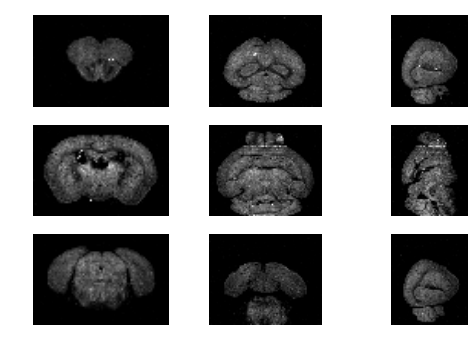

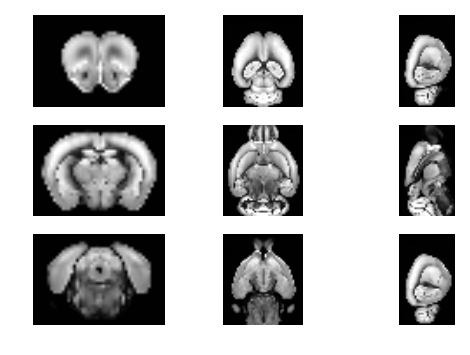

In [3]:
refImg = ndreg.imgDownload('ara_ccf2')
refAnnoImg = ndreg.imgDownload('ara_ccf2', channel="annotation")
inImg = ndreg.imgDownload('eacker01', 'r', 5)

#reorient and rescale the test image
inImgReor = ndreg.imgReorient(inImg, 'lsp', 'rsa')
inImg_ds = ndreg.imgResample(inImgReor, spacing=[.25, .25, .25])
refImg_ds = ndreg.imgResample(refImg, spacing=[.25, .25, .25])

#display the images to be registered
ndreg.imgShow(inImg_ds, vmax=10000)
ndreg.imgShow(refImg_ds, vmax=500)

In [2]:
def register(inImg, baseImg, iterations, MI=False):
    return ndreg.imgAffineComposite(inImg,
                              baseImg,
                              iterations=iterations,
                              useMI=MI,
                              verbose=False)

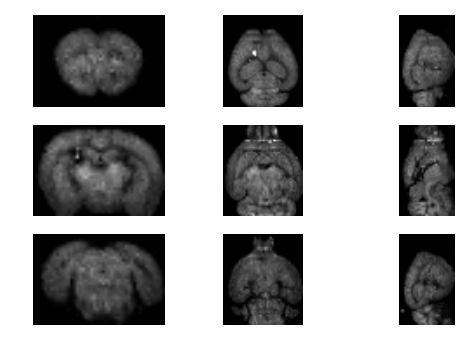

In [10]:
transform = register(inImg_ds, refImg_ds, 200, True)
resultImg = ndreg.imgApplyAffine(inImg_ds,
                                 transform,
                                 size=refImg_ds.GetSize(),
                                 spacing=refImg_ds.GetSpacing())
                                
ndreg.imgShow(resultImg, vmax=10000)

The above image is consistant with the results in the documentation; thus, it is safe to say that the NDReg library can be called functionally.

# 1. Test Methods and Data
In this section, I will create and demonstrate the functionality of all methods that will be used to test the registration techniques

## A. Random Small Transformation Function
The funtions below should be able to generate a bounded random rigid transform, and apply that transform to a body

In [3]:
def getTransform(pitchRange = .1,
                 rollRange = .1,
                 yawRange = .1,
                 xRange = 0.,
                 yRange = 0.,
                 zRange = 0.,
                 pitch=None,
                 yaw=None,
                 roll=None,
                 zT=None,
                 yT=None,
                 xT=None):
    
    #generate a random rigid body transform in given bounds
    a = floatRand(pitchRange-(pitchRange/2.), pitchRange+(pitchRange/2.))
    b = floatRand(yawRange-(yawRange/2.), yawRange+(yawRange/2.))
    c = floatRand(rollRange-(rollRange/2.), rollRange+(rollRange/2.))

    xt = floatRand(xRange-(xRange/2.), xRange+(xRange/2.))
    yt = floatRand(yRange-(yRange/2.), yRange+(yRange/2.))
    zt = floatRand(zRange-(zRange/2.), zRange+(zRange/2.))

    #set default params, if passed
    if yaw is not None:
        a = yaw
    if pitch is not None:
        b = pitch
    if roll is not None:
        c = roll 
    if xT is not None:
        xt = xT
    if yT is not None:
        yt = yT
    if zT is not None:
        zt = zT

    #generate the transform
    transform = np.stack([
        [math.cos(a)*math.cos(b), math.cos(a)*math.sin(b)*math.sin(c)-math.sin(a)*math.cos(c), math.cos(a)*math.sin(b)*math.cos(c)+math.sin(a)*math.sin(c), xt],
        [math.sin(a)*math.cos(b), math.sin(a)*math.sin(b)*math.sin(c)+math.cos(a)*math.cos(c), math.sin(a)*math.sin(b)*math.cos(c)-math.cos(a)*math.sin(c), yt],
        [-math.sin(b), math.cos(b)*math.sin(c), math.cos(b)*math.cos(c), zt],
        [0., 0., 0., 1.]
    ])
    return transform
    
    
def applyRigid(initialVolume, transform, verbose=False):
    #create a body to hold return values
    rigidMatrix = np.zeros_like(initialVolume)  
    
    #create vars to keep track of out of bounds percent
    out = 0.
    
    #convert every voxel
    for z in range(initialVolume.shape[0]):
        for y in range(initialVolume.shape[1]):
            for x in range(initialVolume.shape[2]):
                
                #shift the volume so that the transform is applied to the center, and not the top left back edge
                shift = [initialVolume.shape[2]/2., initialVolume.shape[1]/2., initialVolume.shape[0]/2.]
                shiftedPoint = list(np.subtract([x, y, z], shift))
                shiftedPoint.append(1.)
                
                #calculate the transform, drop the irrelavent 1 at the end
                new = np.dot(transform, shiftedPoint)[:3]
                
                #shift the volume back to its original spot after transform
                final = np.add(new, shift)
                
                #attempt to assign new spot
                try:
                    rigidMatrix[int(final[2]), int(final[1]), int(final[0])] = initialVolume[z, y, x]
                    
                #if transformed place is out of bounds, dont assign it
                except IndexError:
                        out+=1.
                        continue
    #print information, if required
    if verbose:
        print 'Out of bounds fraction: ', out/float(initialVolume.shape[0]*initialVolume.shape[1]*initialVolume.shape[2])
    
    return rigidMatrix

In order to test this function, I will be applying known transformations to it via the default params, and visually verifying the results. The following image will be stacked in a volume in order to test this functionality:

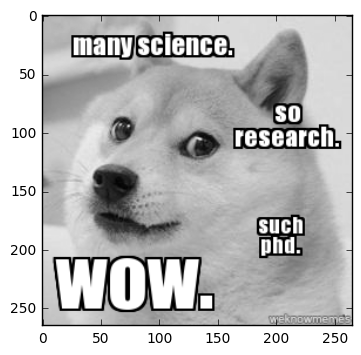

In [9]:
testImg = cv2.imread('../code/tests/synthDat/testImg.jpg', 0)
testVol = np.stack([testImg for i in range(256)])
plt.imshow(testVol[128], cmap='gray')
plt.show()

Out of bounds fraction:  0.00383254716981


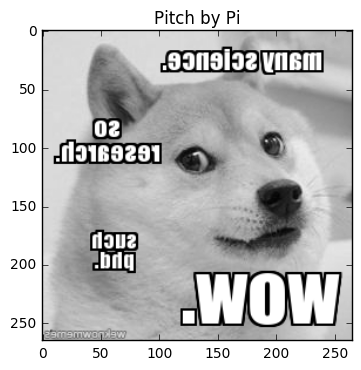

In [76]:
#demonstrate simple rotations and translations
transform = getTransform(pitch=3.14, yaw=0., roll=0., xT=0., yT=0., zT=0.)
newVol = applyRigid(testVol, transform, verbose=True)
fig = plt.figure()
plt.title('Pitch by Pi')
plt.imshow(newVol[128], cmap='gray')
plt.show()

Out of bounds fraction:  0.00377358490566


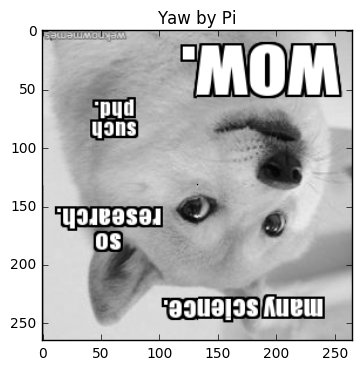

In [78]:
transform = getTransform(pitch=0., yaw=3.14, roll=0., xT=0., yT=0., zT=0.)
newVol = applyRigid(testVol, transform, verbose=True)
fig = plt.figure()
plt.title('Yaw by Pi')
plt.imshow(newVol[128], cmap='gray')
plt.show()

Out of bounds fraction:  0.00383254716981


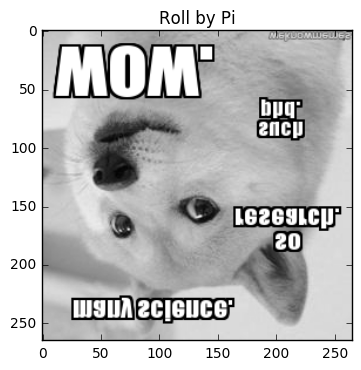

In [26]:
transform = getTransform(pitch=0., yaw=0., roll=3.14, xT=0., yT=0., zT=0.)
newVol = applyRigid(testVol, transform, verbose=True)
fig = plt.figure()
plt.title('Roll by Pi')
plt.imshow(newVol[128], cmap='gray')
plt.show()

Out of bounds fraction:  0.0377358490566


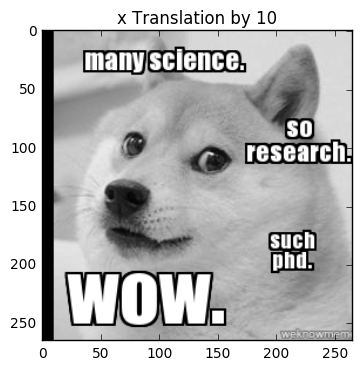

In [27]:
transform = getTransform(pitch=0., yaw=0., roll=0., xT=10., yT=0., zT=0.)
newVol = applyRigid(testVol, transform, verbose=True)
fig = plt.figure()
plt.title('x Translation by 10')
plt.imshow(newVol[128], cmap='gray')
plt.show()

Out of bounds fraction:  0.0377358490566


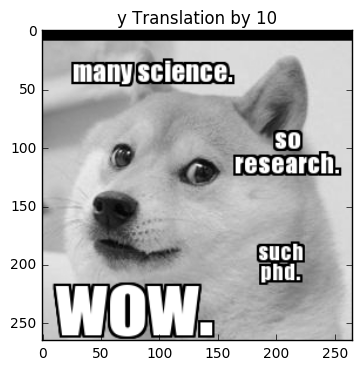

In [28]:
transform = getTransform(pitch=0., yaw=0., roll=0., xT=0., yT=10., zT=0.)
newVol = applyRigid(testVol, transform, verbose=True)
fig = plt.figure()
plt.title('y Translation by 10')
plt.imshow(newVol[128], cmap='gray')
plt.show()

Out of bounds fraction:  0.0390625


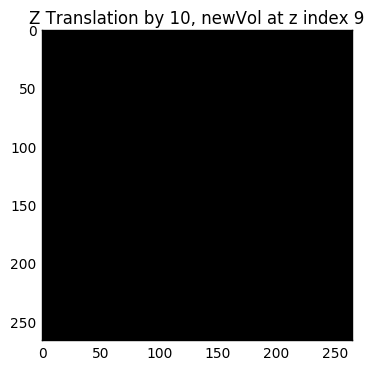

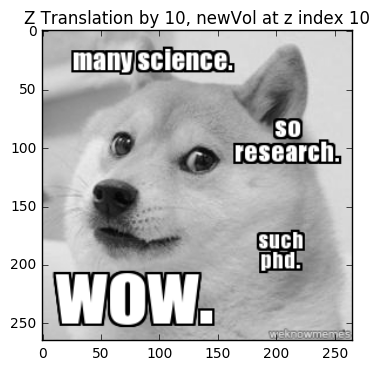

In [31]:
transform = getTransform(pitch=0., yaw=0., roll=0., xT=0., yT=0., zT=10.)
newVol = applyRigid(testVol, transform, verbose=True)
fig = plt.figure()
plt.title('Z Translation by 10, newVol at z index 9')
plt.imshow(newVol[9], cmap='gray')
plt.show()
plt.title('Z Translation by 10, newVol at z index 10')
plt.imshow(newVol[10], cmap='gray')
plt.show()

The above images confirm the functionality of the transform and applyRigid functions. Thus, they can be safely used for testing

## B. Test Data
For some reason, jupyter does not like loading the tiff files directly from our tiffIO driver. Due to this, I have pickled a the true data from time point 1 to be loaded in to jupyter. That data is loaded and displayed below

In [4]:
realData = pickle.load(open('../code/tests/synthDat/realDataRaw_t0.synth', 'r'))
print realData.shape

(280, 1024, 1024)


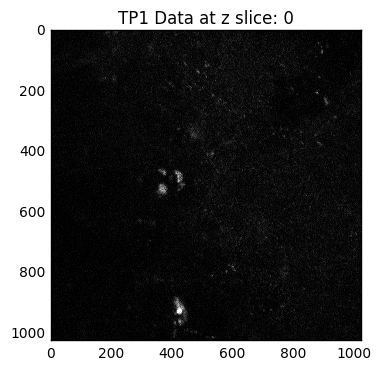

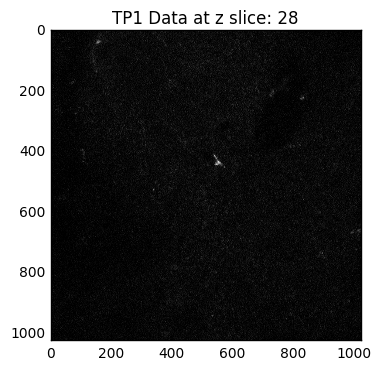

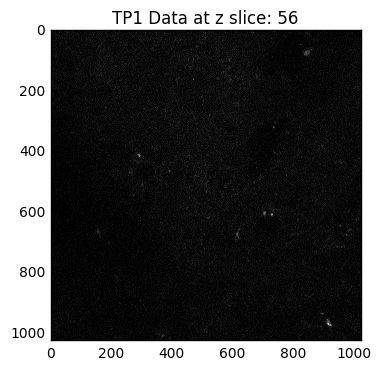

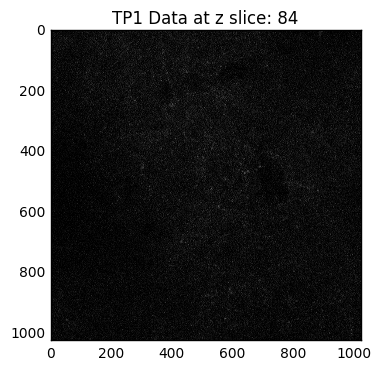

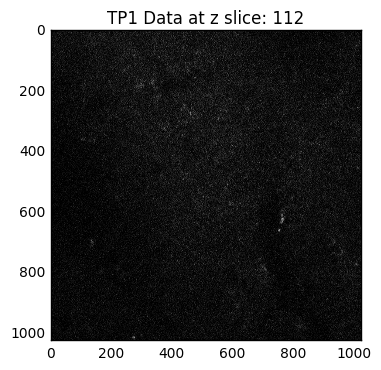

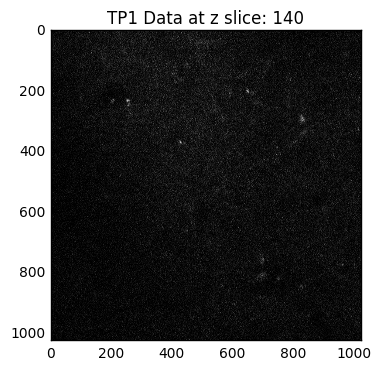

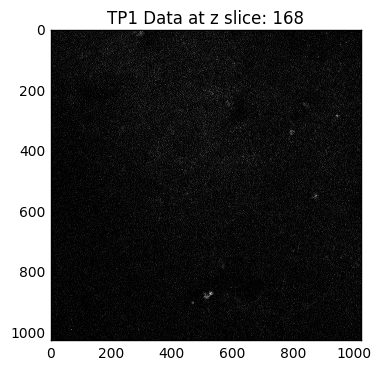

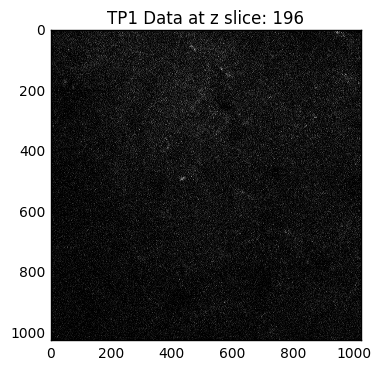

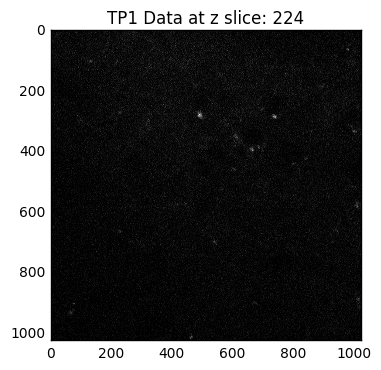

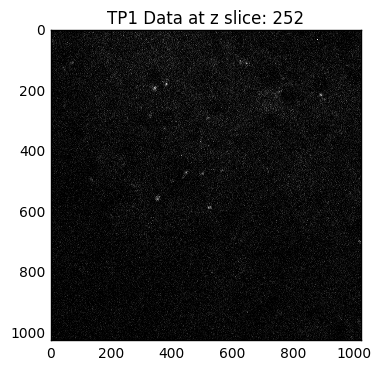

In [5]:
#will display every 28th slice of the data
for i in range(10):
    plt.title('TP1 Data at z slice: ' + str(i*28))
    plt.imshow(realData[i*28], cmap='gray')
    plt.show()

In order to expediate testing, the following 7 slice data portion will be used for all tests. 7 slices were selected due to the pipeline throwing out the top and bottom slices due to ill defined filter operations. This will leave a (5, 1024, 1024) volume.

(7, 1024, 1024)


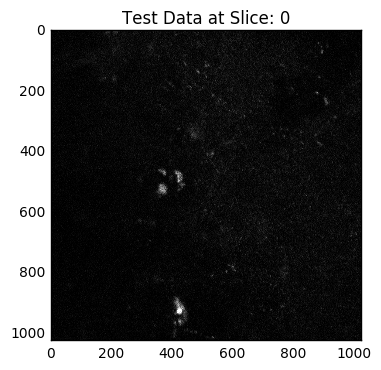

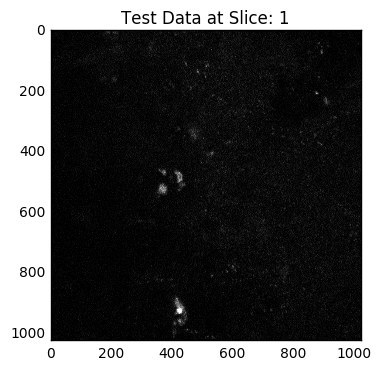

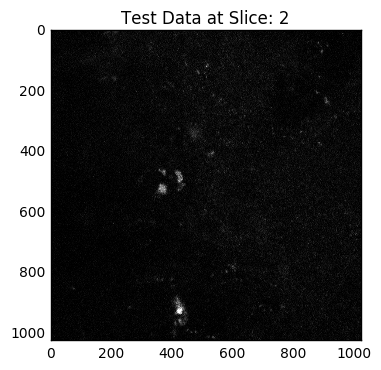

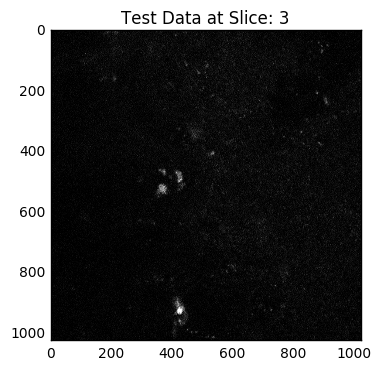

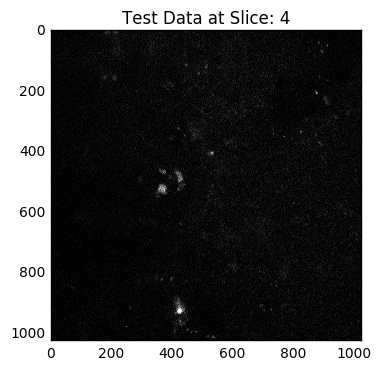

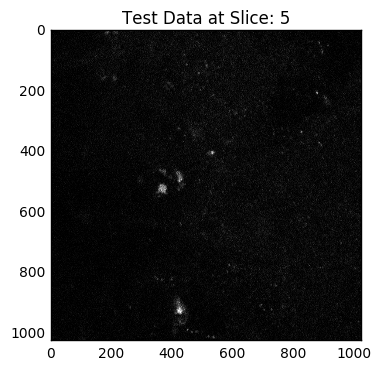

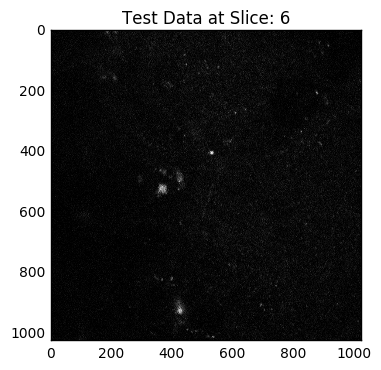

In [6]:
testData = realData[:7]
print testData.shape
for i in range(0, 7):
    fig = plt.figure()
    plt.title('Test Data at Slice: ' + str(i))
    plt.imshow(testData[i], cmap='gray')
    plt.show()

## C. Transformation Visualization Function
The goal of this function is to provide viewers with an intuitive way to visualize the random transformations

In [7]:
def visualizeTransform(transform):
    dat = np.zeros((20, 20, 20))
    for i in range(9, 12):
        for j in range(9, 12):
            for k in range(9, 12):
                dat[i][j][k] = 1.
    applyRigid(dat, transform, False)
    fig = plt.figure()
    plt.title('Transformation Visualization')
    ax = fig.add_subplot(111, projection='3d')
    z, y, x = dat.nonzero()
    ax.scatter(x, y, z, zdir='z', c='r')
    plt.show()

[[ 0.89940424 -0.31576873  0.30226169  0.        ]
 [ 0.39749401  0.87850117 -0.26501738  0.        ]
 [-0.18185305  0.35850496  0.91564385  0.        ]
 [ 0.          0.          0.          1.        ]]


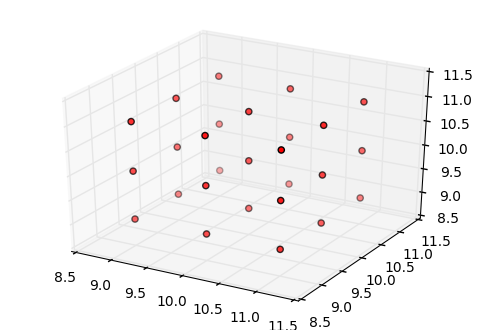

In [68]:
transform = getTransform()
print transform
visualizeTransform(transform)

## D. Test Execution Function
The purpose of this function is, when given two arrays, to run an NDReg test on them and report statistics on the success of said test

In [8]:
def executeTest(testImg, baseImg, gradientIterations = 200, verbose=True):
    
    initialErr = np.sum((np.subtract(baseImg, testImg))**2)
    
    testImgITK = itk.GetImageFromArray(testImg)
    baseImgITK = itk.GetImageFromArray(baseImg)
    
    if verbose:
        print '\tInitial Error: ', initialErr
    transform = register(testImgITK, baseImgITK, gradientIterations)
    
    if verbose:
        print '\tTransform:'
        print transform
         
    regImg = itk.GetArrayFromImage(
        ndreg.imgApplyAffine(
            testImgITK,
            transform,
            size=testImgITK.GetSize(),
            spacing=testImgITK.GetSpacing()
            )
        )

    finalErr = np.sum((np.subtract(baseImg, regImg))**2)
    errReductionRatio = np.subtract(initialErr, finalErr)/float(initialErr)
    
    if verbose:
        print '\tFinal Error: ', finalErr
        print '\tError Reduction Ratio: ', errReductionRatio
    
    return regImg, initialErr, finalErr, errReductionRatio    

# 2. Binary Mask Matching
There are two sub types of binary mask matching that I would like to try:

- Method 1
    1. Run volume A through PLOS pipeline
    2. Create volume B by applying small transform to volume A
    3. Attempt registration
    
- Method 2
    1. Create volume B by applying small transform to volume A
    2. Run both volume A and volume B through the PLOS pipeline
    3. Attempt to register the outputs
    
## A. Method 1

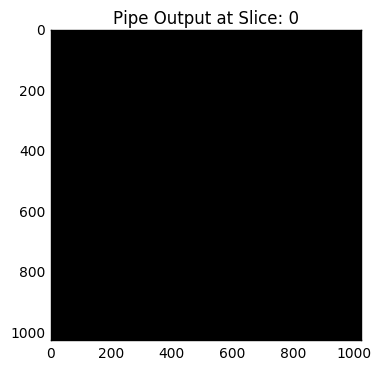

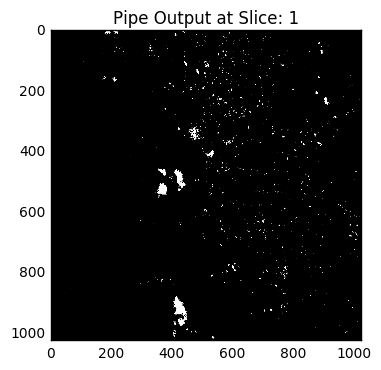

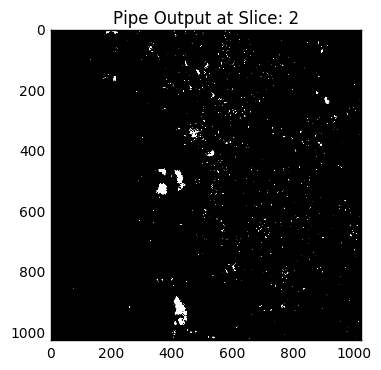

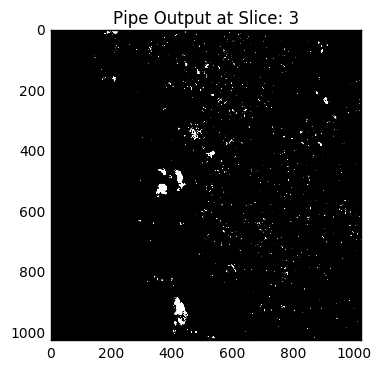

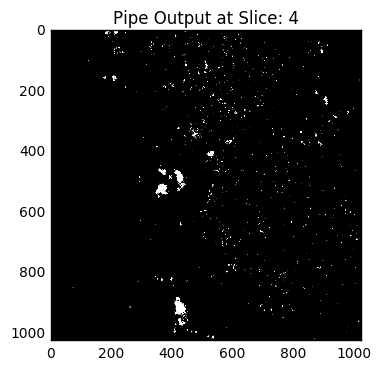

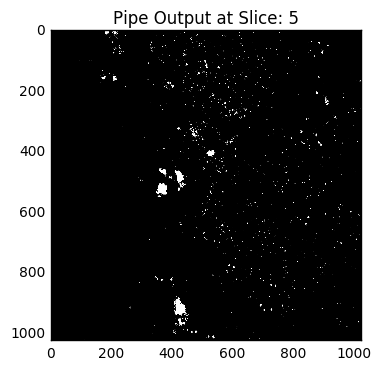

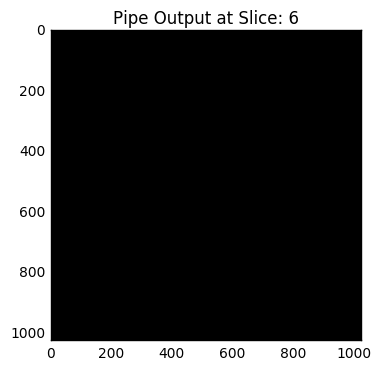

In [10]:
#get output of PLOS and Otsu
outVolume = cLib.otsuVox(pLib.pipeline(testData))
for i in range(0, 7):
    fig = plt.figure()
    plt.title('Pipe Output at Slice: ' + str(i))
    plt.imshow(outVolume[i], cmap='gray')
    plt.show()

In [13]:
#As expected, slices 0 and 6 are ill defined, so remove them
outVolume = outVolume[1:6]
print outVolume.shape

(5, 1024, 1024)


In [14]:
#generate and apply a basic transform to the output
transform = getTransform(pitch=0., yaw=.15, roll=0., xT=0., yT=0., zT=0.)
transformVolume = applyRigid(outVolume, transform, True)

Out of bounds fraction:  0.0318670272827


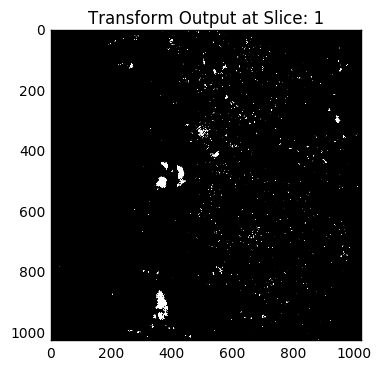

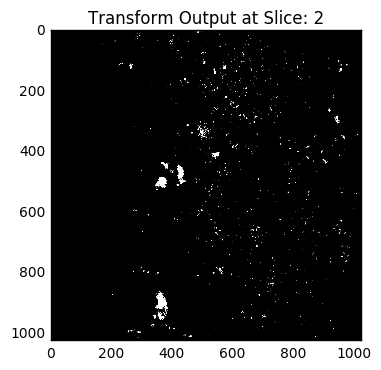

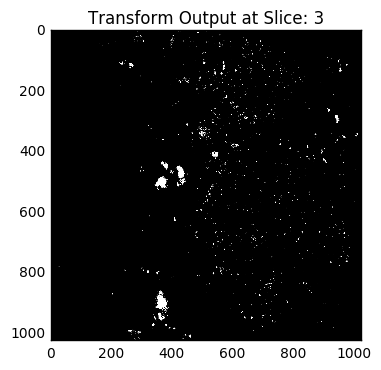

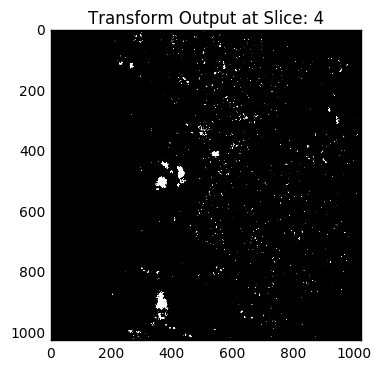

IndexError: index 5 is out of bounds for axis 0 with size 5

In [16]:
for i in range(1, 6):
    fig = plt.figure()
    plt.title('Transform Output at Slice: ' + str(i))
    plt.imshow(transformVolume[i], cmap='gray')
    plt.show()

In [15]:
#Check if NDReg handles the basic case
regImg, initialErr, finalErr, reductionRatio = executeTest(transformVolume, outVolume, 200, verbose=True)

	Initial Error:  110266.0
	Transform:
[0.9975932877997035, 0.05842507161859518, -0.05792548260651925, -0.06162104745726014, 0.9975625945148371, -0.055072088456448946, 0.054513273971632206, 0.05845168451847105, 0.9977840056493715, 0.04733375669943689, -0.053518760362313074, 0.07005213287769078]
	Final Error:  60874.0
	Error Reduction Ratio:  0.447934993561


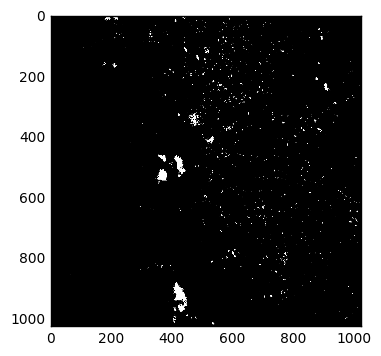

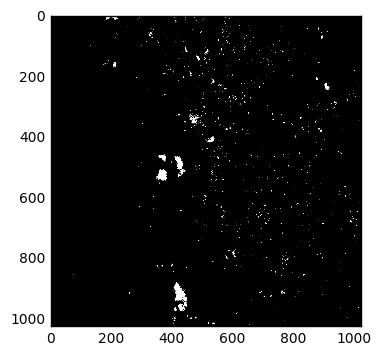

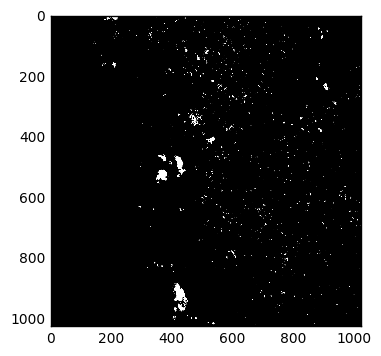

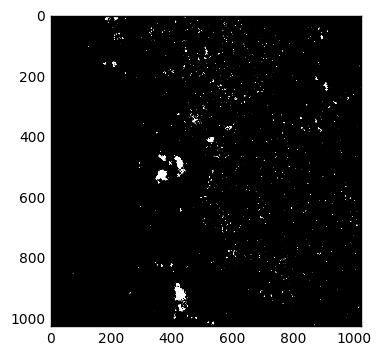

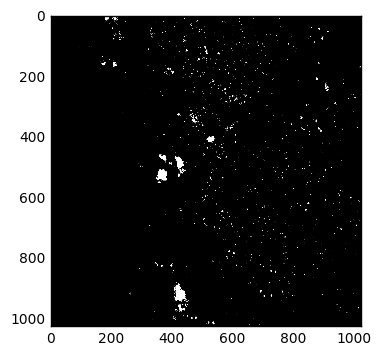

In [16]:
#display the output of the registration
for i in range(regImg.shape[0]):
    fig = plt.figure()
    plt.imshow(outVolume[i], cmap='gray')
    plt.show()

With an error reduction rate of ~44%, the regestration library is not doing a stellar job of aligning the images. I intend to try three methods to imporive this metric:

1. Tune the iterations parameter
2. Tune the intensity of the error
3. Multiple calls to NDReg

### 1. Tuning Iterations
This fix assumes that NDReg can indeed align the images, but is not running gradient descent enough for them to become fully aligned. The code below will attempt to investigate this

In [33]:
fullSimData = []
for iterations in (200, 300, 400, 500):
    testData = []
    for test in range(3):
        print iterations, ' iteration test ', test
        regImg, initialErr, finalErr, reductionRatio = executeTest(transformVolume,
                                                                   outVolume,
                                                                   iterations,
                                                                   verbose=True)
        print '\n\n'
        testData.append([initialErr, finalErr, reductionRatio])
    fullSimData.append(testData)

200  iteration test  0
	Initial Error:  110266.0
	Transform:
[0.9975932877997035, 0.05842507161859518, -0.05792548260651925, -0.06162104745726014, 0.9975625945148371, -0.055072088456448946, 0.054513273971632206, 0.05845168451847105, 0.9977840056493715, 0.04733375669943689, -0.053518760362313074, 0.07005213287769078]
	Final Error:  60874.0
	Error Reduction Ratio:  0.447934993561



200  iteration test  1
	Initial Error:  110266.0
	Transform:
[0.9975932877997035, 0.05842507161859518, -0.05792548260651925, -0.06162104745726014, 0.9975625945148371, -0.055072088456448946, 0.054513273971632206, 0.05845168451847105, 0.9977840056493715, 0.04733375669943689, -0.053518760362313074, 0.07005213287769078]
	Final Error:  60874.0
	Error Reduction Ratio:  0.447934993561



200  iteration test  2
	Initial Error:  110266.0
	Transform:
[0.9975932877997035, 0.05842507161859518, -0.05792548260651925, -0.06162104745726014, 0.9975625945148371, -0.055072088456448946, 0.054513273971632206, 0.05845168451847105,

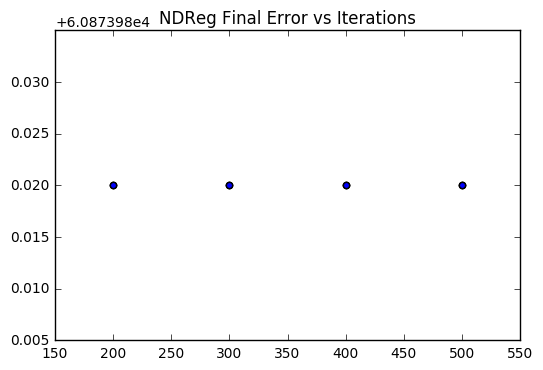

In [35]:
#display the full sim data
fig = plt.figure()
plt.title('NDReg Final Error vs Iterations')

scatterList = []
for trial in fullSimData:
    for test in trial:
        scatterList.append(test[1])
        
plt.scatter([200, 200, 200, 300, 300, 300, 400, 400, 400, 500, 500, 500], scatterList)
plt.show()

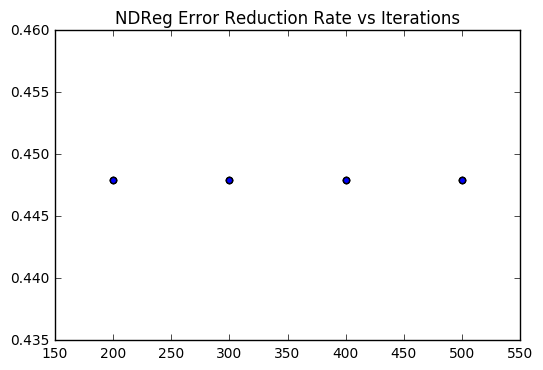

In [38]:
#display the full sim data
fig = plt.figure()
plt.title('NDReg Error Reduction Rate vs Iterations')

scatterList = []
for trial in fullSimData:
    for test in trial:
        scatterList.append(test[2])
        
plt.scatter([200, 200, 200, 300, 300, 300, 400, 400, 400, 500, 500, 500], scatterList)
plt.show()

- The plots above demonstrate that both the error reduction rate and the final error are independent of iteration number, in this circumstance.

- Each iteration test was run 3 times, and all 3 tests resulted in the same final error and error rediction rate.

- Every single test, regardless of iteration trial number, resulted in the same final error and error reduction rate

### 2. Tuning Error Intensity
One possibility is that the magnitude of the error is too great for NDReg to overcome. To check this, I will run NDReg on images which have increasing amounts of error.

In [ ]:
fullSimData = []
for i in range(6):
    transform = getTransform(pitch=0., yaw=i/100., roll=0., xT=0., yT=0., zT=0.)
    transformVolume = applyRigid(outVolume, transform, True)
    print 'NDReg test with yaw displacement of: ', i, ' radians'
    regImg, initialErr, finalErr, reductionRatio = executeTest(transformVolume, outVolume, 300, verbose=True)
    fullSimData.append([initialErr, finalErr, reductionRatio])
    print '\n\n'